# **PRÁCTICA 4:  Deep Learning - Parte 1: RNN**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos


**Contexto**

Los datos financieros de alta calidad son costosos de adquirir y, por lo tanto, rara vez se comparten de forma gratuita. Aquí proporciono los datos históricos completos de precios y volúmenes diarios para todas las acciones y ETF de EE. UU. que se negocian en NYSE, NASDAQ y NYSE MKT. Es uno de los mejores conjuntos de datos de este tipo que puede obtener.

**Contenido**

Los datos (última actualización 10/11/2017) se presentan en formato CSV de la siguiente manera: Fecha, Apertura, Máximo, Mínimo, Cierre, Volumen, IntAbierto. Tenga en cuenta que los precios se han ajustado por dividendos y splits.

**Agradecimientos**

Este conjunto de datos me pertenece. Lo comparto aquí gratis. Puedes hacer con él lo que quieras.

**Inspiración**

Muchos han intentado, pero la mayoría ha fallado, predecir los altibajos del mercado de valores. ¿Puedes hacerlo mejor?



## Importar bibliotecas

El primer paso, como siempre, es importar las bibliotecas requeridas. Ejecute el siguiente script para hacerlo:
Vamos a hacer predicción del valor de un activo financiero de una empresa a partir del valor de los días anteriores.

In [ ]:
# Importamos librerías
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importar conjunto de datos


Los datos que vamos a utilizar para esta práctica se pueden descargar de https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs. Para entrenar nuestro algoritmo, usaremos los precios de las acciones de Apple desde el 1 de enero de 2013 hasta el 31 de diciembre de 2017. En aras de la predicción, usaremos los precios de las acciones de Apple para el mes de enero de 2018. Entonces, para evaluar el desempeño de el algoritmo, descargue también los precios reales de las acciones para el mes de enero de 2018.

In [ ]:
# Usamos Pandas para leerlos y mirarlos un poco
dataset = pd.read_csv("googl.us.txt", delimiter=",")

Veamos ahora cómo se ven nuestros datos. Abra el archivo de capacitación de precios de acciones de Apple que contiene datos de cinco años. Verá que contiene siete columnas: Fecha, Apertura, Máximo, Mínimo, Cierre, Ajuste de cierre y Volumen. Estaremos pronosticando el precio de apertura de las acciones, por lo tanto, no estamos interesados ​​en el resto de las columnas.

In [ ]:
# El dataset tiene 5 características por dia
dataset

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
3328,2017-11-06,1049.100,1052.59,1042.000,1042.680,913954,0
3329,2017-11-07,1049.650,1053.41,1043.000,1052.390,1303832,0
3330,2017-11-08,1050.050,1062.69,1047.050,1058.290,1214469,0
3331,2017-11-09,1048.000,1050.88,1035.850,1047.720,1793994,0


Si queremos mostrar los valores de apertura de cada día:

In [ ]:
dataset['Open']

0         50.000
1         50.505
2         55.375
3         55.620
4         52.480
          ...   
3328    1049.100
3329    1049.650
3330    1050.050
3331    1048.000
3332    1043.870
Name: Open, Length: 3333, dtype: float64

In [ ]:
aa = dataset['Open']
high = dataset['High']
low = dataset['Low']
close = dataset['Close']
volume = dataset['Volume']
openint = dataset['OpenInt']

Si traza los precios de las acciones de apertura contra la fecha, verá el siguiente gráfico:

Text(0.5, 1.0, '3 variables')

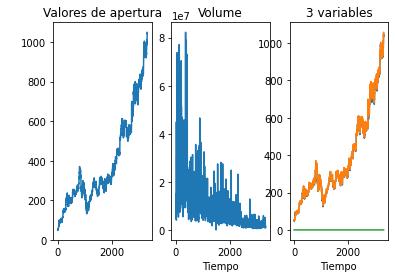

In [ ]:
%matplotlib inline
plt.subplot(131)
p1, = plt.plot(aa)
plt.ylabel(' ')
plt.title('Valores de apertura')

plt.subplot(132)
p2, = plt.plot(volume)
plt.xlabel('Tiempo')
plt.title('Volume')

plt.subplot(133)
p3, = plt.plot(low)
p4, = plt.plot(close)
p5, = plt.plot(openint)
plt.xlabel('Tiempo')
plt.title('3 variables')

# dataset.plot

Puede ver que la tendencia es altamente no lineal y es muy difícil capturar la tendencia usando esta información. Aquí es donde se puede utilizar el poder de LSTM . LSTM (Long Short-Term Memory network) es un tipo de red neuronal recurrente capaz de recordar la información pasada y, al predecir los valores futuros, tiene en cuenta esta información pasada.

La importancia de visualizar los datos la vemos aquí. Como podemos observar, a continuación se muestran en un gráfico, los valores de apertura y de cierre. Estos son muy parecidos, utilizaremos esta infomración para predecir. 

Text(0.5, 1.0, 'Diferencia apertura cierre')

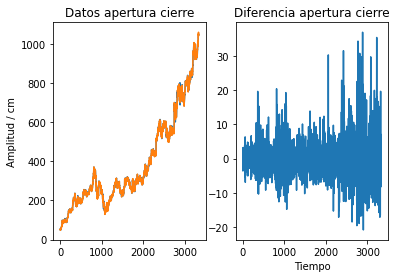

In [ ]:
# Cogemos los datos de apertura y de cierre
googl_op = dataset['Open']
googl_cl = dataset['Close']

%matplotlib inline
plt.subplot(121)
p1, = plt.plot(googl_op)
p3, = plt.plot(googl_cl)
plt.ylabel('Amplitud / cm')
plt.title('Datos apertura cierre')

plt.subplot(122)
p2, = plt.plot(googl_op-googl_cl)
plt.xlabel('Tiempo')
plt.title('Diferencia apertura cierre')

In [ ]:
dataset

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
3328,2017-11-06,1049.100,1052.59,1042.000,1042.680,913954,0
3329,2017-11-07,1049.650,1053.41,1043.000,1052.390,1303832,0
3330,2017-11-08,1050.050,1062.69,1047.050,1058.290,1214469,0
3331,2017-11-09,1048.000,1050.88,1035.850,1047.720,1793994,0


## Preprocesado de los datos

In [ ]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(dataset, test_size = 0.30)

p_train = 0.80 # Porcentaje de train.

train = dataset[:int((len(dataset))* p_train)] 
test = dataset[int((len(dataset))* p_train):]

Como dijimos anteriormente, solo nos interesa el precio de apertura de la acción. Por lo tanto, filtraremos todos los datos de nuestro conjunto de entrenamiento y conservaremos solo los valores de la columna Abrir.

In [ ]:
train

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
2661,2015-03-17,558.160,560.64,554.410,557.610,1444500,0
2662,2015-03-18,557.730,566.51,553.500,566.160,1766200,0
2663,2015-03-19,564.520,566.96,562.120,563.670,1232900,0
2664,2015-03-20,566.710,567.10,564.480,564.950,2216000,0


In [ ]:
xx = train.iloc[:, 1:2].values   

In [ ]:
xx

array([[ 50.   ],
       [ 50.505],
       [ 55.375],
       ...,
       [564.52 ],
       [566.71 ],
       [566.   ]])

Como regla general, siempre que utilice una red neuronal, debe normalizar o escalar sus datos. Usaremos la calse MinMaxScaler de la `sklear.preprocessing`, biblioteca para escalar nuestros datos entre 0 y 1. El `feature_range` parámetro se usa para especificar el rango de los datos escalados. Ejecute el siguiente script:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

X_train = scaler.fit_transform(xx)

Convierta los datos de entrenamiento en la forma correcta
Como dije antes, en un problema de series de tiempo, tenemos que predecir un valor en el tiempo T, con base en los datos de los días TN donde N puede ser cualquier número de pasos. En este artículo, vamos a predecir el precio de apertura de las acciones de los datos en función de los precios de apertura de las acciones de los últimos 60 días. Probé y probé diferentes números y descubrí que los mejores resultados se obtienen cuando se usan los últimos 60 pasos de tiempo. Puede probar diferentes números y ver cómo funciona su algoritmo.

Nuestro conjunto de características debe contener los valores del precio de apertura de las acciones durante los últimos 60 días, mientras que la etiqueta o variable dependiente debe ser el precio de las acciones en el día 61. Ejecute el siguiente script para crear un conjunto de características y etiquetas.

In [ ]:
features_set = []
labels = []
for i in range(60, 2333):
    features_set.append(X_train[i-60:i, 0])
    labels.append(X_train[i, 0])

En el script anterior, creamos dos listas: feature_sety labels. Hay 1260 registros en los datos de entrenamiento. Ejecutamos un bucle que comienza desde el registro 61 y almacena todos los 60 registros anteriores en la feature_setlista. El registro número 61 se almacena en la labelslista.

Necesitamos convertir tanto el feature_set como la labels lista a la matriz numpy antes de que podamos usarla para el entrenamiento. 

In [ ]:
features_set, labels = np.array(features_set), np.array(labels)

Para entrenar LSTM en nuestros datos, necesitamos convertir nuestros datos en la forma aceptada por LSTM. Necesitamos convertir nuestros datos en formato tridimensional. La primera dimensión es el número de registros o filas en el conjunto de datos, que en nuestro caso es 1260. La segunda dimensión es el número de pasos de tiempo que es 60 mientras que la última dimensión es el número de indicadores. Dado que solo estamos usando una función, es decir , Abrir , el número de indicadores será uno.

In [ ]:
X_train = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

## Modelo



**Entrenando el LSTM**

Hemos preprocesado nuestros datos y los hemos convertido al formato deseado. ahora es el momento de crear nuestro LSTM. El modelo LSTM que vamos a crear será un modelo secuencial con varias capas. Agregaremos cuatro capas LSTM a nuestro modelo seguidas de una capa densa que predice el precio futuro de las acciones.

Como primer paso, necesitamos instanciar la Sequential clase. Esta será nuestra clase modelo y agregaremos capas LSTM, Dropout y Dense a este modelo. 

In [ ]:
model = Sequential()

**Creación de capas LSTM y de abandono**

Agreguemos una capa LSTM al modelo que acabamos de crear.  Para agregar una capa al modelo secuencial, `add` se utiliza el método. Dentro del `add`, pasamos nuestra capa LSTM. El primer parámetro de la capa LSTM es el número de neuronas o nodos que queremos en la capa. El segundo parámetro es return_sequences, que se establece en verdadero ya que agregaremos más capas al modelo. El primer parámetro del input_shapees el número de pasos de tiempo mientras que el último parámetro es el número de indicadores.

In [ ]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

Ahora agreguemos una capa de exclusión a nuestro modelo. Se agrega una capa de abandono para evitar el sobreajuste, que es un fenómeno en el que un modelo de aprendizaje automático funciona mejor en los datos de entrenamiento en comparación con los datos de prueba. 

In [ ]:
model.add(Dropout(0.2))

Agreguemos tres capas más de LSTM y abandono a nuestro modelo.

In [ ]:
# Capa 2
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Capa 3
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Capa 4
model.add(LSTM(units=50))
model.add(Dropout(0.2))

**Creando una capa densa**

Para hacer que nuestro modelo sea más robusto, agregamos una capa densa al final del modelo. El número de neuronas en la capa densa se establecerá en 1 ya que queremos predecir un solo valor en la salida.

In [ ]:
# Capa 5 
model.add(Dense(units = 1))

**Compilación de modelos**

Finalmente, necesitamos compilar nuestro LSTM antes de que podamos entrenarlo con los datos de entrenamiento. El siguiente script compila nuestro modelo.

In [ ]:
model.compile(optimizer = 'adam', loss= 'mae')

Llamamos al método de compilación en el objeto de modelo secuencial que es "model" en nuestro caso. Usamos el 
error absoluto medio como función de pérdida y para reducir la pérdida u optimizar el algoritmo, usamos el optimizador de adam.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

**Entrenamiento de algoritmos**

Ahora es el momento de entrenar el modelo que definimos en los pasos anteriores. Para hacerlo, llamamos al método fit en el model y le pasamos nuestras características y etiquetas de entrenamiento como se muestra a continuación:

In [ ]:
model.fit(X_train, labels, epochs = 100, batch_size = 32)

## Probando nuestro LSTM

Hemos entrenado con éxito nuestro LSTM, ahora es el momento de probar el rendimiento de nuestro algoritmo en el conjunto de prueba al predecir los precios de apertura de las acciones para el mes de enero de 2018. Sin embargo, como hicimos con los datos de entrenamiento, necesitamos convertir nuestro datos de prueba en el formato correcto.

Primero importemos nuestros datos de prueba.

In [ ]:
X_test = test.iloc[:, 1:2].values  

Como ya comentamos con anterioridad, como hicimos con los datos de entrenamiento, eliminamos todas las columnas de los datos de prueba excepto la columna que contiene los precios de las acciones de apertura.

**Conversión de datos de prueba al formato correcto**

Para cada día de enero de 2018, queremos que nuestro conjunto de funciones contenga los precios de apertura de las acciones de los 60 días anteriores. Para el 1 de enero, necesitamos los precios de las acciones de los 60 días anteriores. Para hacerlo, necesitamos concatenar nuestros datos de entrenamiento y datos de prueba antes del preprocesamiento. 

In [ ]:
total = pd.concat((train['Open'], test['Open']), axis=0)

Ahora preparemos nuestras entradas de prueba. La entrada para cada día debe contener los precios de apertura de las acciones de los 60 días anteriores. Eso significa que necesitamos los precios de las acciones de apertura para los 20 días de prueba del mes de enero de 2018 y los 60 precios de las acciones de los últimos 60 días para el conjunto de entrenamiento. Ejecute el siguiente script para obtener esos 80 valores.

In [ ]:
test_inputs = total[len(total) - len(X_test) - 60:].values

Como hicimos con el conjunto de entrenamiento, necesitamos escalar nuestros datos de prueba.

In [ ]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

Escalamos nuestros datos, ahora preparemos nuestro conjunto de entrada de prueba final que contendrá los 60 precios de acciones anteriores para el mes de enero. 

In [ ]:
test_features = []
for i in range(60, 80):
    test_features.append(test_inputs[i-60:i, 0])

Finalmente, necesitamos convertir nuestros datos al formato tridimensional que se puede usar como entrada para el LSTM.

In [ ]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

Haciendo predicciones
Ahora es el momento de ver la magia. Preprocesamos nuestros datos de prueba y ahora podemos usarlos para hacer predicciones. Para hacerlo, simplemente necesitamos llamar al predictmétodo en el modelo que entrenamos.

In [ ]:
predictions = model.predict(test_features)

Dado que escalamos nuestros datos, las predicciones realizadas por el LSTM también se escalan. Necesitamos revertir la predicción escalada a sus valores reales. Para hacerlo, podemos usar el ìnverse_transformmétodo del objeto escalador que creamos durante el entrenamiento.

In [ ]:
predictions = scaler.inverse_transform(predictions)

In [ ]:
# EVALUACION
score_train = model.evaluate(X_train, labels, batch_size=32)
score_test = model.evaluate(test_features, predictions, batch_size=32)

print('MAE en el entrenamiento:', np.round(score_train))
print('MAE en el test:', np.round(score_test))

1/1 [==============================] - 2s 2s/step - loss: 550.6030
MAE en el entrenamiento: 0.0
MAE en el test: 551.0


Finalmente, veamos qué tan bien predijo nuestro algoritmo los precios futuros de las acciones visualmente.

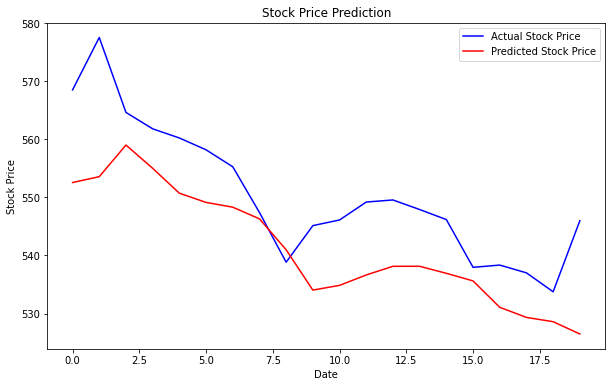

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(X_test[0:20], color='blue', label='Actual Stock Price')
plt.plot(predictions , color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

En el resultado, la línea azul representa los precios de las acciones reales para el mes de enero de 2018, mientras que la línea roja representa los precios de las acciones pronosticados. Puede ver claramente que nuestro algoritmo ha podido capturar la tendencia general. Los precios pronosticados también ven una tendencia alcista al principio seguida de una tendencia bajista o bajista al final. 

## Conclusión

Una red de memoria larga a corto plazo (LSTM) es una de las redes neuronales más utilizadas para el análisis de series temporales. La capacidad de LSTM para recordar información previa lo hace ideal para tales tareas. En este ejercico se ha visto cómo podemos usar LSTM para la predicción del precio de las acciones. 

En diferencia con los casos anteriores lo que hemos hecho es: Primero, entendimos nuestros datos, como hemos visto, esto es algo muy importante porque así nos damos cuenta que datos tenemos que seleccionar y cuáles son las variables más importantes para predecir el precio de las acciones de Google. 

Además tambien controlamos némero el parámetro de los modelos, no ni es un número pequeño de parámetro como en los ejercicios 1 y 3 (parámetros 11 y 0 respectrvimente) ni un valor de parámetro 81 como en el ejercico 2. En este caso, tenemos 51 parámentros.